# Welcome to Inscopy...

  

In [1]:
# Here we import the libaries that we'll use.
import inscopy.main as inx # The main Inscopy library
import matplotlib.pyplot as plt


# Loading the data
In order to run this example notebook, two example datafiles have been included. The are:

    - Mouse3_AC1_test.csv (containing all the identified cells of one recording)   
    - Mouse3_AC1_TTL.csv (Containing the TTL pulses in that same recording)
    
The files are obtained during a simple conditioning task in which a CS+ predicts a stimulus and a CS- is without scheduled concequences. The CS+, CS- and stimulus all have a duration of 2sec.


In [2]:
# Two load data functions are included in Inscopy, one for data and one for TTL pulses
cells = inx.load_cells('Mouse3_AC1_test.csv')
TLL = inx.load_TTL('Mouse3_AC1_TTL_test.csv')


Unable to grab pulses from: EX-LED


Let's have a look at how the data is organized. The cells are stored in a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). Every column contains a cell, the index contains a timeline.

In [3]:
# Print the head of the dataframe
cells.head()

,C014,C015,C019,C025,C026,C027,C032,C034,C036,C037,...,C072,C074,C075,C076,C077,C082,C087,C088,C090,C098
,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,...,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted
0.000000,221.23030,419.1952,231.8218,742.5095,1353.8890,227.8089,43.416420,-325.8921,422.5137,-276.3569,...,262.73330,501.2041,-0.590720,232.5705,716.9009,795.0726,581.6196,88.45294,-7.050067,146.8416
0.049961,125.99520,336.5704,254.4867,525.0764,1304.1980,254.7474,159.273000,-147.1034,145.5259,-68.4526,...,63.22830,612.5137,155.886000,315.2365,796.4816,489.1010,578.2794,195.21210,-31.871020,159.7640
0.099922,115.22560,329.6065,102.1143,798.1436,970.5417,130.3991,72.904040,-143.3747,284.4962,-269.1349,...,285.99220,599.7084,6.539417,309.6529,708.6279,497.0079,491.3867,25.77842,147.278700,197.9656
0.149883,-52.70831,398.1596,221.1164,370.0634,942.3802,281.1639,-64.085540,-342.6367,287.6556,-106.3225,...,66.54649,359.8383,152.757800,378.4610,421.2542,643.1846,470.8666,-32.66871,84.086980,201.4958
0.199844,34.40885,450.8571,227.3858,796.7164,993.2611,139.7210,9.392694,-286.8622,226.6733,-320.9226,...,339.38660,323.0055,347.798700,187.4776,653.2042,282.1373,337.4106,-37.89618,102.271700,291.7189


The TLL timestamps meanwhile are stored in a Python dict. The keys of the dict are the TLL channels on the nVista system. The values are again DataFrames, but in this case every row is a pulse on the channel.

In [23]:
# Look at the available keys
print('The available channels are:')
[print(i) for i in TLL.keys()]

# Look at one in particular
print('This is for instance what GPIO-1 looks like in this datafile:')
TLL['GPIO-1'].head()

The available channels are:
Digital GPI 0
Digital GPI 1
Digital GPI 2
Digital GPI 3
Digital GPI 4
Digital GPI 5
Digital GPI 6
Digital GPI 7
Digital GPO 0
Digital GPO 1
Digital GPO 2
Digital GPO 3
Digital GPO 4
Digital GPO 5
Digital GPO 6
Digital GPO 7
GPIO-1
GPIO-2
GPIO-3
GPIO-4
OG-LED
DI-LED
e-focus
BNC Sync Output
BNC Trigger Input
This is for instance what GPIO-1 looks like in this datafile:


,Start,Stop,Duration
0,88.8342,90.8358,2.0016
1,124.7032,126.7050,2.0018
2,183.0524,185.0542,2.0018
3,210.5018,212.5028,2.0010
4,298.5552,300.5560,2.0008


# First look at the data
In the experiment from the example data, the stimulus is indicated by the pulses on channel GPIO-1, while the CS+ is indicated by the <i>offset</i> of a 1sec pulse on channel GPIO-2 and the CS- by the <i>offset</i> of a 0.5sec pulse on channel CPIO-2. Below we take a first look at the data.

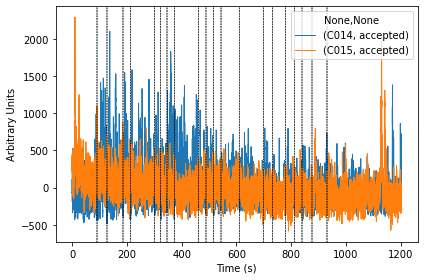

In [5]:
# Let's look at the first two cells and the stimulus and plot the whole session.
first_two_cells = cells.iloc[:, :2]
stimulus = TLL['GPIO-1']

# We use the function 'plot_cells' to plot the data
inx.plot_cells(first_two_cells, stimulus)

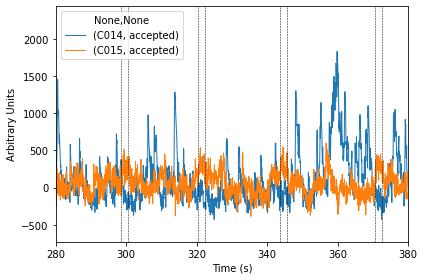

In [9]:
# Higher time resolution of a series of 3 stimuli:
inx.plot_cells(first_two_cells, stimulus, window=[280, 380])



In [12]:
# Grab peri event data

# We're going to look at the stimulus onset (note that 'start' at the end.)
stamps = TLL['GPIO-1'].Start

# Grab PE_data
# NOTE: we are putting in ALL the cells (the entire DataFrame).
PE_data = inx.peri_event(cells, stamps, window=10) 

# The output is a dictionary with all the cells as keys. Let's have a look at the first cell:
PE_data['C014'].head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-10.00,84.867820,293.8329,59.28467,271.9401,274.055800,-194.67630,-118.418000,1016.1620,514.1473,-217.02950,-75.439580,-104.4755,36.81921,-298.6285,-207.70700,-18.628530,-27.06467,50.40192,-66.090490,-254.0691
-9.95,101.527900,279.9279,-30.33431,191.9528,310.782000,-280.07850,-74.365680,1000.0520,580.6703,-196.63220,0.658461,-121.8734,-93.29137,-102.0664,-127.90710,-74.395150,-45.01199,-58.75743,-187.319000,-156.3191
-9.90,5.697567,216.1025,-61.91505,272.8240,177.299800,-253.18890,2.327093,929.0688,618.9327,-100.07000,-166.432100,-114.5904,49.10563,-220.5701,-147.18240,-3.136431,-38.13815,-255.26640,-167.882400,-199.0899
-9.85,20.775010,261.5420,-152.73540,154.8592,-4.031449,-39.38573,15.611290,803.3035,653.1757,12.90992,-152.894800,-123.0150,63.10105,-164.9971,-205.47950,23.805320,-144.66730,-90.82121,4.659212,-87.0826
-9.80,85.351910,225.5889,-150.71610,136.3820,57.981070,-250.42760,-34.927170,718.7255,507.5587,-111.39110,-106.291700,-232.1729,53.18783,-169.7326,-75.94897,-226.007100,-173.32910,-174.34060,86.320910,-185.3730


As you can see the output is a Dataframe. The index is a timeline (T=0 is the stamp) and the columns are the individual trials. In this case the stimulus was presented 19 times, so the peri-event data has 19 columns. We'll plot the PE_data below, but first we have to talk about normalization.

### Z-score
...

### min-max
...

### auROC
...

In [26]:
PE_data_normalized = inx.normalize_PE(PE_data['C015'], method='z-score')
PE_data_normalized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-10.00,0.771163,1.936149,1.313325,-0.052368,0.322961,0.620437,0.786508,0.371174,-1.003603,-1.110123,-1.021221,0.500589,0.824658,1.244971,0.897327,-2.720718,-1.859990,-2.302984,0.444653,1.104464
-9.95,-0.144311,1.908412,0.556298,0.055644,0.066757,1.552184,-0.329418,0.106144,-2.662991,-1.869569,1.553493,0.387316,0.819922,1.482951,-0.002714,-0.849482,-0.877800,-1.047757,0.020356,0.058300
-9.90,-0.815696,2.852071,2.316653,1.115077,-0.341677,1.471056,-0.953015,0.738594,-1.162282,-1.939332,-0.964843,-0.662871,1.078405,1.282745,-0.038466,-0.630930,-0.465416,-1.594740,1.465712,1.263630
-9.85,-0.887758,3.079178,1.206095,0.774487,-0.173151,1.040351,-0.768191,-0.132581,-0.021767,-1.636759,-0.481336,0.247137,-0.609582,2.395396,1.221782,0.126659,-0.760784,-1.881297,2.014797,-0.808632
-9.80,-1.183612,2.752495,1.360424,1.352600,-0.179043,0.753672,0.942660,0.543633,-1.390298,-1.497097,0.977807,1.183666,0.922156,1.489536,0.963127,-0.748226,-1.039381,-1.463393,1.228322,1.108474


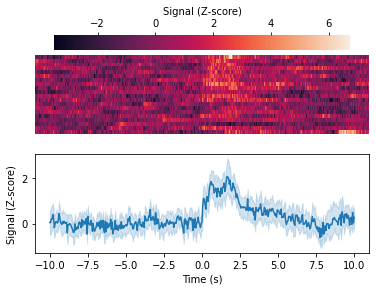

In [22]:
# Finally plot
inx.plot_PE(PE_data_normalized)